In [1]:
import numpy as np
import random
from keras import callbacks
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils
import string
from typing import List, Tuple
import re

random.seed(10)
np.random.seed(10)

In [2]:
import pandas as pd
from pandas import DataFrame


def load_lyrics(csv_path: str) -> DataFrame:
    df = pd.read_csv(csv_path, sep='\n', header=None)
    res = df.iloc[:, 0].str.rstrip(r'&, ').str.extract(r'([^,]+),([^,]+),(.+)')
    res.columns = ['artist', 'title', 'lyrics']
    return res

def load_songs(path) -> List[str]:
    df = load_lyrics(path)
    for i, song in enumerate(list(df['lyrics'])):
        song += " EOF"
        modified_song = re.sub(r"\([^()]*\)", "", song)
        modified_song = re.sub(r"\([^()]*\)", "", song)
        modified_song = modified_song.replace("chorus", "").lower()
        # modified_song = modified_song.replace("chorus", "").replace("&", "silencio").lower()
        regex = re.compile('[%s]' % re.escape(string.punctuation.replace("&", "")))
        modified_song = regex.sub('', modified_song)
        df.loc[i, 'lyrics'] = modified_song
    return df

In [3]:
def create_x_y(songs, tokenize, total_words, max_len) -> Tuple[np.ndarray, np.ndarray]:
    input_sequences = []
    midi_meta = []
    for index, row in songs.iterrows():
      line = row['lyrics']
    # for line in songs:
      token_list = tokenize.texts_to_sequences([line])[0]
      midi_metadata = row.drop(['artist', 'title', 'lyrics', 'filename']).values
      for i in range(1, len(token_list)):
          n_gram_sequence = token_list[:i + 1]
          input_sequences.append(n_gram_sequence)
          midi_meta.append(midi_metadata)
    print(input_sequences[:10])
    # max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_len, padding='pre'))
    x = input_sequences[:, :-1]
    x_midi = np.array(midi_meta)
    y = input_sequences[:, -1]
    y = utils.to_categorical(y, num_classes=total_words)
    return x, x_midi, y #, max_sequence_len

def split_df_to_train_val(df, ratio):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_val = df[~mask]
    return df_train, df_val

In [4]:
class LyricsGenerator(object):

    def __init__(self, embedding_dim: int, vocab_size: int, input_size: int, midi_features_size: int, embedding_matrix: np.ndarray):
        input_lyrics = Input(shape=(input_size,))
        embedding_layer = Embedding(
            vocab_size,
            embedding_dim,
            input_length=input_size,
            weights=[embedding_matrix],
            # embeddings_initializer=initializers.Constant(embedding_matrix),
            trainable=True,
        )(input_lyrics)
        lstm = LSTM(units=embedding_dim)(embedding_layer)
        lyrics_model = Dropout(0.2)(lstm)

        input_midi =  Input(shape=(midi_features_size,))
        midi_model = Dense(50, activation='relu')(input_midi)
        midi_model = Dense(10, activation='relu')(midi_model)

        final_model_1 = concatenate([lyrics_model, midi_model])
        final_model = Dense(units=vocab_size, activation='softmax')(final_model_1)
        self.model = Model(inputs=[input_lyrics, input_midi], outputs=final_model)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def fit(self, x, y, hyper_parameters):
        callback = callbacks.EarlyStopping(monitor='loss', patience=3)
        callback2 = callbacks.LearningRateScheduler(self._lr_scheduler)
        # callback3 = callbacks.ModelCheckpoint('lyrics_model.h5', save_best_only=True, monitor='val_loss', mode='min')
        # callback = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
        # history = self.model.fit(x, y, epochs=100, verbose=1)
        history = self.model.fit(x, y, batch_size=hyper_parameters['batch_size'], epochs=hyper_parameters['epochs'],
                                 callbacks=[callback],
                                 # callbacks=[callback, callback2],
                                 verbose=1, validation_split=hyper_parameters['validation_split'],
                                 validation_data=hyper_parameters['val_data'])
        self.model.save('lyrics_model.h5')
        
        return history

    def _lr_scheduler(self, epoch, lr):
        return 0.95 * lr

    def evaluate(self, x, y):
        predictions = self.model.evaluate(x, y)
        return predictions

    # to get a picture of loss progress.
    def plot_metric(self, history: History, metric: str = 'loss') -> None:
        import matplotlib.pyplot as plt
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])
        plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df_songs = load_songs('/content/drive/MyDrive/DL/Assignment_3/Lyrics/lyrics_train_set.csv')

In [7]:
df_songs['lyrics'][0]

'goodbye norma jean & though i never knew you at all & you had the grace to hold yourself & while those around you crawled & they crawled out of the woodwork & and they whispered into your brain & they set you on the treadmill & and they made you change your name & and it seems to me you lived your life & like a candle in the wind & never knowing who to cling to & when the rain set in & and i would liked to have known you & but i was just a kid & your candle burned out long before & your legend ever did & loneliness was tough & the toughest role you ever played & hollywood created a superstar & and pain was the price you paid & even when you died & oh the press still hounded you & all the papers had to say & was that marilyn was found in the nude & and it seems to me you lived your life & like a candle in the wind & never knowing who to cling to & when the rain set in & and i would liked to have known you & but i was just a kid & your candle burned out long before & your legend ever di

In [8]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DL/Assignment_3/midi_files.zip',"r") as zip_ref:
  zip_ref.extractall("temp_dir")

In [9]:
!pip install MIDIFile

In [10]:
from os import listdir
from MIDI import MIDIFile


files_in_dir = [f for f in listdir("temp_dir/midi_files") if re.match('.*\.mid', f)]
df_midi = pd.DataFrame(columns=['filename', 'numerator', 'denominator', 'clocksPerTick', 'demisemiquaverPer24Clocks', 'key', 'mode', 'tempo'])
def parse(file):
    c=MIDIFile(file)
    c.parse()
    numerator = denominator = clocksPerTick = demisemiquaverPer24Clocks = -1
    key = mode = 'unknown'
    tempo = -1
    for idx, track in enumerate(c):
        track.parse()
        data = str(track)
        if 'Time Signature -> ' in data and numerator == -1:
          t_s = data.split('Time Signature -> ')[1].split('\n',1)[0].split(" ")
          numerator = t_s[0].split("numerator=")[1]
          denominator = t_s[1].split("denominator=")[1]
          clocksPerTick = t_s[2].split("clocksPerTick=")[1]
          demisemiquaverPer24Clocks = t_s[3].split("demisemiquaverPer24Clocks=")[1]

        if 'Key Signature -> ' in data and key == 'unknown':
          k_s = data.split('Key Signature -> ')[1].split('\n',1)[0].split(" ")
          key = k_s[0].split("key=")[1]
          mode = k_s[1].split("mode=")[1]

        if 'Set Tempo -> tempo=' in data and tempo == -1:
          tempo = data.split('Set Tempo -> tempo=')[1].split('\n',1)[0]
    
    return numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo #str(track)
for i, f in enumerate(files_in_dir):

    try:
      numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo = parse("temp_dir/midi_files/" + f)
    except UnicodeDecodeError as e:
      continue
    
    print(f'n {numerator} d {denominator} cpt {clocksPerTick} dp24c {demisemiquaverPer24Clocks}')
    print(f'key {key} mode {mode} tempo {tempo}')
    df_tmp = pd.DataFrame([[f.lower(),numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo ]], columns=['filename', 'numerator', 'denominator', 'clocksPerTick', 'demisemiquaverPer24Clocks', 'key', 'mode', 'tempo'])
    df_midi= pd.concat([df_midi, df_tmp])

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 126.31584
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 173.34768
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 134.57952
n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 120.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 141.1764
n 2 d 4 cpt 96 dp24c 8
key B mode major tempo 130.90896
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 173.49408


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 138.46152
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 169.41168
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 97.95912


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 130.90896
n 3 d 4 cpt 24 dp24c 8
key C mode major tempo 79.99992
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 120.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key D mode major tempo 108.27072
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key D mode major tempo 121.00848
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 96.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/

n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 104.34768
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 99.95136


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 221.53848
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 90.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 151.57896
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 126.2052


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 175.60968
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 180.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 2 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 82.28568


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 133.33344


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 102.85704
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 165.5172


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 199.99992
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 115.2
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 128.57136
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 110.76912
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 160.00008


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    len

n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 214.92528
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 142.57416
n -1 d -1 cpt -1 dp24c -1
key E mode major tempo 102.85704
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 158.2416
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 240.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 83.72088
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 117.07296


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 112.5
n -1 d -1 cpt -1 dp24c -1
key E mode major tempo 156.52176
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 122.034
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 110.76912


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key E mode major tempo 102.85704
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 102.85704
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 128.57136
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 153.16992
n 6 d 8 cpt 12 dp24c 8
key C mode major tempo 257.14296


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key E mode major tempo 180.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 108.27048
n 2 d 4 cpt 96 dp24c 8
key D mode major tempo 169.41168
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unknown chunk type      - skipping
Unk

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    len

n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 94.73688
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 110.76912
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 257.14296


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 158.24184


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key E mode major tempo 110.76912
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 175.60968


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 3 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 116.12904


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 60.0
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 132.11016
n 4 d 4 cpt 36 dp24c 8
key C mode major tempo 75.78936
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 125.21736
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 148.45368
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 145.45464
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 221.53848


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key D mode major tempo 115.2
Unknown chunk type ~x9  - skipping
n 4 d 4 cpt 24 dp24c 8
key D mode major tempo 144.0
n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 106.66656


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 141.1764
n 2 d 4 cpt 24 dp24c 8
key A mode major tempo 135.84912
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 106.66656
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 70.58808
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 106.50888
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 114.2856
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 7 d 8 cpt 12 dp24c 8
key unknown mode unknown tempo 192.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 165.5172
n -1 d -1 cpt -1 dp24c -1
key D mode major tempo 144.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 96.0
n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 225.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 146.9388
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 123.0768
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 163.63632
n 4 d 4 cpt 24 dp24c 8
key C# mode major tempo 66.66672
n 6 d 8 cpt 12 dp24c 8
key D mode major tempo 70.58832
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 133.33344
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 109.0908
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 124.13784
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 160.00008
n -1 d -1 cpt -1 dp24c -1
key C mod

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 130.9092


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 119.00832
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 126.31584
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 240.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 156.52176


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 101.4084
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 68.57136
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 102.85704
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 180.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 133.3332
n 6 d 4 cpt 24 dp24c 8
key C mode major tempo 91.60296
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 145.45464
n 6 d 8 cpt 12 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 163.63632


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 130.9092
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 105.88224
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 205.71432
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer

n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n 2 d 2 cpt 24 dp24c 8
key G mode major tempo 110.76912
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 163.63632
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key B mode major tempo 211.76472
n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 128.57136
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 137.14272
n 6 d 4 cpt 24 dp24c 8
key C mode major tempo 84.90576


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 122.034
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 133.33344
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 79.99992
n 12 d 8 cpt 24 dp24c 8
key unknown mode unknown tempo 72.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    len

n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 99.31032
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 117.0732


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 120.0
n 6 d 4 cpt 24 dp24c 8
key C mode major tempo 78.94728


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-pack

n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 130.9092
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 90.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 187.01304
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 139.80576
n 2 d 4 cpt 24 dp24c 8
key A mode major tempo 144.0
n 4 d 4 cpt 24 dp24c 8
key E mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 85.71432
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 106.66656


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 99.31032
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 109.0908
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 102.85704
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 105.88224
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 163.2
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 169.014
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 114.2856
n 2 d 4 cpt 36 dp24c 8
key C mode major tempo 351.21936
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 107.46264
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 138.46152
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 128.57136
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 103.59696
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 122.034
n 4 d 4 cpt 24 dp24c 8
key E mode major tempo 133.3332


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 133.33344


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 192.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 122.034
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 115.2
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 117.0732
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 99.31032
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 150.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    sel

n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 154.83864
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 109.9236


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 79.55808
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 100.6992
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 110.76912


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 116.1288
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 121.00848


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 158.24184
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 158.24184


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 160.00008
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 113.38584
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 146.93856


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key D mode major tempo 128.57136
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 102.85704
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 180.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0
n 4 d 4 cpt 24 dp24c 8
key D mode major tempo 175.60968
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 192.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 130.9092
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 126.3156
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 69.90288
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 133.33344
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 106.66656
n 3 d 4 cpt 24 dp24c 8
key E mode major tempo 82.28568
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 142.57416
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 71.64168
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 125.21736
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 160.00008


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer

n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 109.9236


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 127.43352
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 160.00008
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 102.85704
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 126.31584


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range

n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 125.21736
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 118.03272


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MID

n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key D mode major tempo 180.0
n 4 d 4 cpt 24 dp24c 8
key E mode major tempo 169.41168
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 105.88224
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 110.76912
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 143.4264


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 119.00832
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 119.00808
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0
n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 84.70584
n 4 d 4 cpt 96 dp24c 8
key unknown mode unknown tempo 154.83864
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 110.76912
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 99.31032


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 96 dp24c 8
key unknown mode unknown tempo 211.76448


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 125.21736
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 144.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 160.00008
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 100.00008


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 133.33344


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 76.59576
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 153.19128
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 109.0908
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 159.99984


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer

n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 114.2856
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 144.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 130.90896
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 79.1208
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 125.21736
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 133.3332
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 122.034
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 100.00008
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 205.71432
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 144.0
n 3 d 4 cpt 24 dp24c 8
key C mode major tempo 171.42864


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key A mode major tempo 96.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 122.034


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 114.2856
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 234.7188
n -1 d -1 cpt -1 dp24c -1
key A mode major tempo 211.76472


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key B mode major tempo 205.71432
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 218.18184
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer

n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 148.45368
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 145.45464
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 151.57896
n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 115.2
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 106.66656


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.at

n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key D mode major tempo 208.6956
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 49.18032
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 138.46152
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 110.75688
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 122.03376


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer

n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 150.0
n 1 d 4 cpt 24 dp24c 8
key C mode major tempo 119.99976
n -1 d -1 cpt -1 dp24c -1
key B mode major tempo 120.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MID

n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 126.31584
n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 130.90896
Unknown chunk type  J  - skipping


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 72.0
n -1 d -1 cpt -1 dp24c -1
key C mode minor tempo 67.28952


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 163.1064
n 2 d 4 cpt 24 dp24c 8
key A mode major tempo 154.83864
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 120.0
n 4 d 4 cpt 96 dp24c 8
key unknown mode unknown tempo 96.64416
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 72.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 122.034
n 2 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 165.5172
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 104.34768


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 109.0908
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 128.57136
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 214.92528
n 4 d 4 cpt 24 dp24c 8
key E mode major tempo 81.81816
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 128.57136
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 160.00008


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    sel

n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 130.9092
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n 4 d 4 cpt 96 dp24c 8
key unknown mode unknown tempo 144.0
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 151.57872


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 120.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 54, in attributes
    mode = { 0 : 'major', 1 : 'minor' }[_bytes[1]]
KeyError: 255


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 124.13784
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 119.00832


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 144.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 184.61544
n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 173.49408
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 151.57536
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 84.70584
n 4 d 4 cpt 24 dp24c 8
key G mode minor tempo 102.85704
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 69.5652
n -1 d -1 cpt -1 dp24c -1
key D mode major tempo 156.52176
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 109.0908
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 208.6956


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 54, in attributes
    mode = { 0 : 'major', 1 : 'minor' }[_bytes[1]]
KeyError: 255
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 54, in attributes
    mode = { 0 : 'major', 1 : 'minor' }[_bytes[1]]
KeyError: 255
Traceback (most recent call last):
  File "/usr/local/lib/python3.

n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 150.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 134.57952
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 113.38584
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 100.00008


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 117.0732
n 2 d 4 cpt 96 dp24c 8
key C mode major tempo 180.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 130.9092
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 138.46152
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 199.99992


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 141.1764
n 2 d 4 cpt 96 dp24c 8
key C mode major tempo 202.8168
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 124.13784
n -1 d -1 cpt -1 dp24c -1
key D mode major tempo 114.2856


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 113.3856
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 154.8
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 180.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 128.57136
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 111.62784
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MID

n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 116.5992
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 117.0732
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 60.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range

n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 115.2
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 156.52152
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 108.27048
n -1 d -1 cpt -1 dp24c -1
key A mode major tempo 130.9092
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 109.0908
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 138.46152
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 130.9092


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 134.57952
n -1 d -1 cpt -1 dp24c -1
key E mode major tempo 208.6956
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 61.5384
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 240.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 208.6956


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 115.2
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 90.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/

n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 146.9388
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 92.90328
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 105.10944
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 120.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key F# mode major tempo 144.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 151.57896
n -1 d -1 cpt -1 dp24c -1
key D mode major tempo 128.57136
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 150.47016
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 125.21736
n -1 d -1 cpt -1 dp24c -1
key A mode major tempo 223.46328


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MID

n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 154.83864
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 161.79768
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 48.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 141.1764
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 248.27592
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range

n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 110.76912
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n 4 d 4 cpt 96 dp24c 8
key unknown mode unknown tempo 161.79768
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 161.79768
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 151.57896
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 112.5
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 125.21736
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 124.13784
n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 209.46648
n 12 d 8 cpt 12 dp24c 8
key D mode major tempo 112.5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 127.43352
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 110.76912
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 221.53848
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 141.1764
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key D mode major tempo 158.24184
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 218.18184


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 112.5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 92.3076
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 124.13784
n 4 d 4 cpt 96 dp24c 8
key E mode major tempo 102.564
n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 158.24184
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 184.61544
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 145.45464
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range

n 2 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 114.2856
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 109.0908
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 166.47408


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 138.46152
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 115.2
n 3 d 4 cpt 24 dp24c 8
key C mode major tempo 134.57952
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 159.99984
n 4 d 4 cpt 24 dp24c 8
key C mode minor tempo 73.84608
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 205.71432
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 156.52176


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 261.81816
n 4 d 4 cpt 24 dp24c 8
key E mode major tempo 151.57872
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 130.9092
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 110.76912
n 6 d 8 cpt 12 dp24c 8
key C mode major tempo 192.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 71.64168
n 4 d 4 cpt 96 dp24c 8
key unknown mode unknown tempo 180.0
n 4 d 4 cpt 24 dp24c 8
key D mode major tempo 180.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 197.26008
n 3 d 4 cpt 24 dp24c 8
key C mode major tempo 87.27264
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 110.76912
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 148.45368
n 6 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 97.95912
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 225.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 151.9788
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 142.57416
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 180.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 100.00008
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 144.0
n 6 d 8 cpt 12 dp24c 8
key C mode major tempo 225.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 84.70584
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 163.63632
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 293.8776
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 125.21736


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-pack

n -1 d -1 cpt -1 dp24c -1
key D mode major tempo 82.28568
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 154.83864
Unknown chunk type <SCR - skipping
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 90.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 205.71432
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0
Unknown chunk type  - skipping
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 96.0
n 4 d 4 cpt 24 dp24c 8
key F# mode major tempo 156.52176


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 3 d 2 cpt 48 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 127.43352


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 6 d 8 cpt 12 dp24c 8
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key D mode major tempo 205.71432
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key E mode major tempo 115.2
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer

n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 72.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 130.9092


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    len

n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 130.9092
n 6 d 4 cpt 24 dp24c 8
key C mode major tempo 78.26088
n 3 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 142.57416
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 146.93856
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 146.9388
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 101.4084
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 148.45344
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 194.5944
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 199.99992


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 211.76472
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 74.22672
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0
n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 102.85704
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 192.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 124.13784
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 75.39264
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 108.27072


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key E mode major tempo 139.80576
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 189.47352


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/

n -1 d -1 cpt -1 dp24c -1
key D mode major tempo 105.88224
n 4 d 4 cpt 24 dp24c 8
key D mode major tempo 160.00008
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 240.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 110.76912
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 156.52152
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 163.63632
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 197.26008
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 125.21736
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 138.46152
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 99.31032


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 144.0
n 7 d 4 cpt 24 dp24c 8
key C mode major tempo 159.99984
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 205.71432


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer

n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 64.00008
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 130.90896
n 4 d 4 cpt 96 dp24c 8
key unknown mode unknown tempo 161.79768
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 106.66656
n -1 d -1 cpt -1 dp24c -1
key A mode major tempo 144.0
n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 163.63632
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 126.31584
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 109.9236
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 221.5128
n 2 d 4 cpt 24 dp24c 8
key D mode major tempo 108.27072
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 153.19152
n 12 d 8 cpt 36 dp24c 8
key unknown mode unknown tempo 90.56592


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 156.52152
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 130.9092
n 3 d 4 cpt 24 dp24c 8
key C mode major tempo 87.27264


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    sel

n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 93.5064
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 173.49408


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 179.91
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo 104.34768


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 76.59576
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 169.41168
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 221.53824


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key A mode major tempo 130.9092
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 57.6
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 142.57416


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 118.03272
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 128.57112


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 211.76448
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 144.0
n -1 d -1 cpt -1 dp24c -1
key A mode major tempo 115.2
n 8 d 8 cpt 12 dp24c 8
key C mode major tempo 232.25808
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 236.06568
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 96.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 127.43352
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 100.00008
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key D mode major tempo 148.45368
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 158.24184
Unknown chunk type  of  - skipping
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key B mode major tempo 214.5732
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 150.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 160.00008
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 112.5
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 132.11016
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 115.2
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 197.26032
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 104.34768
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 180.0
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 159.99984
n 4 d 4 cpt 24 dp24c 8
key E mode major tempo 117.0732
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo -1
n 4 d 4 cpt 24 dp24c 8
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 33, in parse
    event = MetaEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 75, in __init__
    self.attributes = self.message.attributes(self.data)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 55, in attributes
    return OrderedDict(key=self.key(_bytes[0]),mode=mode)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/meta.py", line 31, in key
    return ['C','G','D','A','E','B','F#','C#'][n]
IndexError: list index out of range


n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 139.80576
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 110.76912
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1
n -1 d -1 cpt -1 dp24c -1
key G mode major tempo 91.71984
n 4 d 4 cpt 24 dp24c 8
key G mode major tempo 218.18184
n -1 d -1 cpt -1 dp24c -1
key C mode major tempo 129.72984


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 37, in parse
    event = MIDIEvent(time,self.buffer)
  File "/usr/local/lib/python3.7/dist-packages/MIDI/Events/midi.py", line 43, in __init__
    length = len(self.message) if self.message else 0
TypeError: 'method' object cannot be interpreted as an integer


n 2 d 4 cpt 24 dp24c 8
key C mode major tempo 214.92528
n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo -1


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/MIDI/chunks/track.py", line 30, in parse
    eventType=self.buffer[0]
IndexError: index out of range


n -1 d -1 cpt -1 dp24c -1
key unknown mode unknown tempo 125.21736
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 144.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 110.76912
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 120.0
n 4 d 4 cpt 24 dp24c 8
key C mode major tempo 175.60968


In [11]:
df_midi

,filename,numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo
0,elmore_james_-_dust_my_broom.mid,4,4,24,8,C,major,126.31584
0,eric_clapton_-_wonderful_tonight_-_live_extnd_...,4,4,24,8,C,major,173.34768
0,the_corrs_-_someday.mid,4,4,24,8,C,major,134.57952
0,cat_stevens_-_oh_very_young.mid,2,4,24,8,C,major,120.0
0,dionne_warwick_-_heartbreaker.mid,4,4,24,8,C,major,141.1764
...,...,...,...,...,...,...,...,...
0,chuck_mangione_-_feels_so_good.mid,-1,-1,-1,-1,unknown,unknown,125.21736
0,cardigans_-_erase_and_rewind.mid,4,4,24,8,C,major,144.0
0,gene_vincent_-_be_bop_a_lula.mid,4,4,24,8,C,major,110.76912
0,abba_-_super_trouper.mid,4,4,24,8,C,major,120.0


In [12]:
df_songs['filename'] = df_songs['artist'].str.replace(' ', "_") + "_-_" + df_songs['title'].str.replace(' ', "_") + ".mid"
df_merged = pd.merge(df_songs, df_midi, on="filename")

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

scalers = []
columns = ['numerator', 'denominator','clocksPerTick', 'demisemiquaverPer24Clocks', 'tempo']
for col in columns:
  scaler = MinMaxScaler()
  scaled_features = scaler.fit_transform(df_merged[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_merged.index, columns=[col])
  df_merged[col] = tmp_df[col]
  scalers.append(scaler)


onehot_encoders = []
columns = ['key', 'mode']
for col in columns:
  onehot_encoder = OneHotEncoder(sparse=False)
  scaled_features = onehot_encoder.fit_transform(df_merged[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_merged.index)
  tmp_df.columns = onehot_encoder.get_feature_names([col])
  df_merged.drop([col] ,axis=1, inplace=True)
  df_merged = pd.concat([df_merged, tmp_df ], axis=1)
  onehot_encoders.append(onehot_encoder)

In [14]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DL/Assignment_3/glove.6B.zip',"r") as zip_ref:
  zip_ref.extractall("glove")

In [15]:
tokenize = Tokenizer(filters='')
tokenize.fit_on_texts(df_merged['lyrics'])
tokenize.fit_on_texts(['eof'])
total_words = len(tokenize.word_index) + 1
embedding_dim = 300

In [16]:
import pickle
f = open("tokenizer_pickle", "wb")
pickle.dump(tokenize, f)
f.close()

In [17]:
#taken from https://gist.github.com/shubham0204/531f75c37c49362c9b61a11865496177
import numpy as np
import pickle
import os

# You need to download the GloVe embeddings ( in txt files ) from here -> http://nlp.stanford.edu/data/glove.6B.zip

# The vocabulary size. It is the value of `len( tokenizer.word_index )+1`
vocab_size = total_words #int(input('Enter Vocabulary Size : '))

# The file to the GloVe file. For instance, "glove.6B/glove.6B.50d" where "50" represents the output dimension of the embedding.
glove_path = "/content/glove/glove.6B.300d.txt" #input('Enter path to GloVe text file : ')

# The filepath of the tf.keras.preprocessing.text.Tokenizer object in pickled form. 
# This object was earlier used to tokenize the question and answer pairs. 
tokenizer_path = "/content/tokenizer_pickle" #input('Enter pickled Tokenizer path : ')

# The output directory where the files will be stored.
output_dir = "/content" #input( 'Enter path of output directory : ')

# The output dimensions for the embedding. If the `glove_path` refers to `glove.6B.50d` then this argument should be equal to 50.
output_dim = embedding_dim #int(input('Enter output dimension for Embedding : '))

# The filename for the saved numpy array. For example, "embedding_matrix.npy"
embedding_filename = "embedding_matrix_6b.npy" #input('Enter file name : ' )

# load the whole embedding into memory
embeddings_index = dict()
f = open( glove_path , encoding='utf8' )
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

tokenizer = pickle.load( open( tokenizer_path , 'rb' ) )

embedding_matrix = np.zeros((vocab_size, output_dim))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

np.save( os.path.join( output_dir , '{}'.format( embedding_filename )) , embedding_matrix )

Loaded 400001 word vectors.


In [18]:
# gloveFile = "/content/glove/glove.6B.300d.txt"
# import numpy as np
# def loadGloveModel(gloveFile):
#     print ("Loading Glove Model")
#     with open(gloveFile, encoding="utf8" ) as f:
#         content = f.readlines()
#     model = {}
#     for line in content:
#         splitLine = line.split()
#         word = splitLine[0]
#         embedding = np.array([float(val) for val in splitLine[1:]])
#         model[word] = embedding
#     print ("Done.",len(model)," words loaded!")
#     return model

# model = loadGloveModel(gloveFile)



In [19]:
# words1=[',']
# vector_2 = np.mean([model[word] for word in words1],axis=0) ## Got error message

In [20]:
# vector_2

In [21]:
embedding_matrixs =  np.load("/content/embedding_matrix_6b.npy")
embedding_matrixs.shape

(7517, 300)

In [22]:
def remove_words(words: List[str], songs):
    resulting_songs = []
    for song in songs:
        result = song
        for word in words:
            result = result.replace(word, '')
        resulting_songs.append(result)
    return resulting_songs

In [23]:
import json
non_words_json = json.load(open('/content/drive/MyDrive/DL/Assignment_3/Lyrics/non_words.json', "r"))
non_words_list = non_words_json["non existing words"]
df_merged['lyrics'] = remove_words(non_words_list, df_merged['lyrics'])

In [24]:
# max_sequence_len = df_merged['lyrics'].str.split().apply(len).max()-1
max_sequence_len = 5
df_train, df_val = split_df_to_train_val(df_merged, ratio=0.9)
x_train, x_train_midi, y_train = create_x_y(df_train, tokenize, total_words, max_sequence_len)
x_val, x_val_midi, y_val = create_x_y(df_val, tokenize, total_words, max_sequence_len)
x_train_midi = np.asarray(x_train_midi).astype('float32')
x_val_midi = np.asarray(x_val_midi).astype('float32')

[[220, 2434], [220, 2434, 2435], [220, 2434, 2435, 1], [220, 2434, 2435, 1, 320], [220, 2434, 2435, 1, 320, 4], [220, 2434, 2435, 1, 320, 4, 47], [220, 2434, 2435, 1, 320, 4, 47, 224], [220, 2434, 2435, 1, 320, 4, 47, 224, 2], [220, 2434, 2435, 1, 320, 4, 47, 224, 2, 68], [220, 2434, 2435, 1, 320, 4, 47, 224, 2, 68, 19]]
[[724, 24], [724, 24, 8], [724, 24, 8, 1], [724, 24, 8, 1, 4], [724, 24, 8, 1, 4, 54], [724, 24, 8, 1, 4, 54, 3564], [724, 24, 8, 1, 4, 54, 3564, 36], [724, 24, 8, 1, 4, 54, 3564, 36, 276], [724, 24, 8, 1, 4, 54, 3564, 36, 276, 19], [724, 24, 8, 1, 4, 54, 3564, 36, 276, 19, 243]]


In [25]:
# x_train, y_train, x_val, y_val, max_sequence_len = create_x_y_train(cleaned_songs, tokenize, total_words)
# x_test, y_test = create_x_y(cleaned_test_songs, tokenize, total_words, max_sequence_len)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 4, 300)       2255100     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 300)          721200      embedding[0][0]                  
______________________________________________________________________________________________

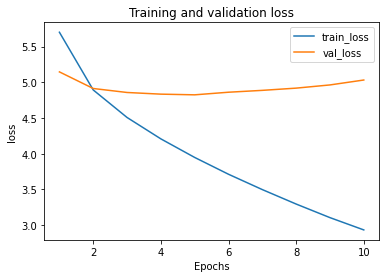

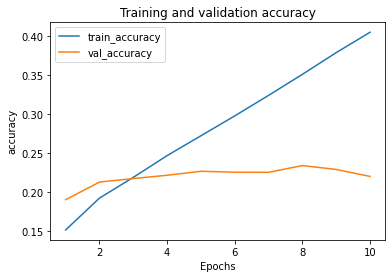

In [26]:
# Train model
parameters = {
    'batch_size' : 512 ,
    'validation_split' : None ,
    'epochs' : 10 ,
    'val_data' :  ([x_val, x_val_midi], y_val)
}
lyrics_generator = LyricsGenerator(embedding_dim, total_words, x_train.shape[1], x_train_midi.shape[1], embedding_matrixs)
h = lyrics_generator.fit([x_train, x_train_midi], y_train, parameters)
lyrics_generator.plot_metric(h)
lyrics_generator.plot_metric(h, metric="accuracy")

In [27]:
def generate_text(x, eof, model, max_sequence_len, vocab_size):
    seed_text, midi_metadata = x
    next_word = ""
    word_indices = np.arange(vocab_size) + 1
    word_count = 0
    while next_word != eof and word_count < 1500:
        token_list = tokenize.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_proba = model.model.predict_on_batch([token_list, midi_metadata])
        # print(token_list)
        # print(predicted_proba.reshape((predicted_proba.shape[1])).shape)
        # sample the word index acording to predicted proba
        chosen_index = np.random.choice(word_indices ,1 ,replace=False, p=predicted_proba.reshape((predicted_proba.shape[1])))
        word_count += 1
        seed_text += " " + tokenize.sequences_to_texts([chosen_index])[0]
    print(f'total number of words {word_count}')
    return seed_text

In [28]:
df_songs_test = load_songs('/content/drive/MyDrive/DL/Assignment_3/Lyrics/lyrics_test_set.csv')
df_songs_test['filename'] = df_songs_test['artist'].str.replace(' ', "_") + "_-" + df_songs_test['title'].str.replace(' ', "_") + ".mid"
df_test = pd.merge(df_songs_test, df_midi, on="filename")

columns = ['numerator', 'denominator','clocksPerTick', 'demisemiquaverPer24Clocks', 'tempo']
for i, col in enumerate(columns):
  scaled_features = scalers[i].transform(df_test[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_test.index, columns=[col])
  df_test[col] = tmp_df[col]


columns = ['key', 'mode']
for i, col in enumerate(columns):
  scaled_features = onehot_encoders[i].transform(df_test[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_test.index)
  tmp_df.columns = onehot_encoders[i].get_feature_names([col])
  df_test.drop([col] ,axis=1, inplace=True)
  df_test = pd.concat([df_test, tmp_df ], axis=1)

x_test, x_test_midi, y_test = create_x_y(df_test, tokenize, total_words, max_sequence_len)
# x_test_midi = np.asarray(x_test_midi[0]).astype('float32').reshape(1,x_test_midi[0].size)
x_test_midi = np.asarray(x_test_midi).astype('float32')

[[333, 13], [333, 13, 113], [333, 13, 113, 111], [333, 13, 113, 111, 8], [333, 13, 113, 111, 8, 13], [333, 13, 113, 111, 8, 13, 272], [333, 13, 113, 111, 8, 13, 272, 678], [333, 13, 113, 111, 8, 13, 272, 678, 1], [333, 13, 113, 111, 8, 13, 272, 678, 1, 29], [333, 13, 113, 111, 8, 13, 272, 678, 1, 29, 2]]


In [29]:
prediction = lyrics_generator.evaluate([x_test, x_test_midi], y_test)
print(prediction)

39/39 [==============================] - 0s 4ms/step - loss: 4.8798 - accuracy: 0.2327
[4.879792213439941, 0.23268921673297882]


In [30]:
print(generate_text(['forgive', x_test_midi[0].reshape(1,x_test_midi[0].size)], "eof" , lyrics_generator , max_sequence_len, total_words).replace("&","\n"))

total number of words 1500
forgive my not our all before i things you taking world you beat you hot you jesus youre me you when for my drop you has and prostitute you its me you measure oh a have you play you it but to keeping meets survive you you ever by you you you by that you come hey you you mine you with my away you when to yeah you do the only hand gone day you them do so outside the ive within im bitches you im with in heart you found everybody got mundane you long you somewhere tell my devotion you you you see my my her all in mankind you one you yule so met my dime glad your thing were no better home you do and know be matter you gonna night a theyve fly you mind but feel you is ill inside of that in queen you sometimes the dream god it anything you build my too heads your lot you no stars need of another stupid fool you was he you holding it you come a ward a hold large i when to field you no will marmalade leave the hangin where i come is with the craft mind you wish stormy